# Híbrido CIC-IDS-2017

La última fase de la evaluación conlleva la evaluación de los modelos en dominios similares. Para ello, se utilizó el CIC-IDS-2017, el conjunto de datos predecesor del utilizado en  este proyecto. A continuación se muestran las
métricas y el porcentaje de ataques detectados para el modelo híbrido.

## Librerías necesarias

In [1]:
from sklearn.metrics import accuracy_score
from keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from numpy import argmax
from joblib import load
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import itertools
def plot_confusion_matrix(cm, title, classes=['normal', 'abnormal'], save=False, save_as='MyFigure.png', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    
    fmt = '.1%'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment='center', color='white' if cm[i,j] > thresh else 'black')
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    if save:
        plt.savefig(save_as, dpi=100)

## Modelado

In [3]:
class StackedClassifier():
    
    def __init__(self):
        self.models = {
            'Autoencoder': load_model('/home/jovyan/My-Notebooks/Stacked/autoencoder'),
            'Random Forest' : load('/home/jovyan/My-Notebooks/Stacked/rf-hyper/RF.joblib')
            }
        self.th = 0.05
 
    def __reshape_AE(self, X):
        return np.delete(X, [1,2,7,8,9,10,11,13,15,18,20,21], 1)

    def __train_models(self, X_train_ae, y_train_ae, X_train_rf, y_train_rf):
        
        normal_train_data = X_train_ae[np.where(y_train_ae == 0)]
        stop_early = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
        self.models['Autoencoder'].fit(normal_train_data, normal_train_data, epochs=500, verbose=0, batch_size=512, shuffle=True, callbacks=[stop_early])
        
        reconstructions = self.models['Autoencoder'].predict(X_train_ae)
        loss = tf.keras.losses.mae(reconstructions, X_train_ae)
        preds_ae = tf.math.less(self.th, loss)
        y_train_ae = np.where(y_train_ae > 0, 1, y_train_ae)
        print('Accuracy for Autoencoder:', accuracy_score(y_train_ae.astype(bool), preds_ae))
        
        self.models['Random Forest'].fit(X_train_rf, y_train_rf)
        preds_rf = self.models['Random Forest'].predict(X_train_rf)
        y_train_rf = np.where(y_train_ae > 0, 1, y_train_ae)
        preds_rf = np.where(y_train_ae > 0, 1, y_train_ae)
        print('Accuracy for Random Forest:', accuracy_score(y_train_rf, preds_rf))

    def __stacked_dataset(self, X_stacked):
        global stackX
        stackX = 0
        
        X_ae = self.__reshape_AE(X_stacked)
        reconstructions = self.models['Autoencoder'].predict(X_ae)
        loss = tf.keras.losses.mae(reconstructions, X_ae)
        stackX = pd.DataFrame()
        stackX['AE'] = tf.math.less(self.th, loss)

        yhat = self.models['Random Forest'].predict(X_stacked)
        yhat = np.where(yhat > 0, 1, yhat).astype(bool)
        stackX['RF'] = yhat
        
        return stackX.values

    def kFold(self, inputx, inputy, splits):
        
        scores = []
        skfold = StratifiedKFold(n_splits = splits)
        
        for train_index, test_index in skfold.split(inputx, inputy):
            X_train, X_test = inputx[train_index], inputx[test_index]
            y_train, y_test = inputy[train_index], inputy[test_index]
            
            self.fit(X_train, y_train)
            
            scores.append(accuracy_score(y_test, self.predict(X_test)))
        
        return scores
    
    def fit(self, inputx, inputy):
        # split training set
        X_train, X_stacked, y_train, y_stacked = train_test_split(inputx, inputy, test_size=0.33, random_state=100)
        X_train_ae = self.__reshape_AE(X_train)
        
        self.__train_models(X_train_ae, y_train, X_train, y_train)
        # create dataset using ensemble
        stackedX = self.__stacked_dataset(X_stacked)
        # fit standalone model
        LR = LogisticRegression()
        y_stacked = np.where(y_stacked > 0, 1, y_stacked).astype(bool)
        LR.fit(stackedX, y_stacked)
        self.stacked_model = LR
    
    def predict(self, inputX):
        # create dataset using ensemble
        stackedX = self.__stacked_dataset(inputX)
        # make a prediction
        yhat = self.stacked_model.predict(stackedX)
        return yhat

## Carga del conjunto de datos

In [4]:
df = pd.read_csv('/home/jovyan/CIC-IDS-2017/CIC-IDS-2017-train.csv', sep=',', low_memory=False)
y_train = df.pop('Label')
X_train = df.values

In [5]:
sc = StackedClassifier()

## Entrenamiento

In [6]:
sc.fit(X_train, y_train)

14657/14657 [==============================] - 16s 1ms/step
Accuracy for Autoencoder: 0.6085287846481876
Accuracy for Random Forest: 1.0
7219/7219 [==============================] - 10s 1ms/step


In [7]:
df = pd.read_csv('/home/jovyan/CIC-IDS-2017/CIC-IDS-2017-test.csv', sep=',', low_memory=False)
y_test = df.pop('Label')
X_test = df.values

In [8]:
%%time
preds = sc.predict(X_test)

25429/25429 [==============================] - 33s 1ms/step
CPU times: user 51.5 s, sys: 6.52 s, total: 58 s
Wall time: 45.9 s


              precision    recall  f1-score   support

           0    0.99977   0.98986   0.99479    647015
           1    0.96210   0.99910   0.98025    166705

    accuracy                        0.99175    813720
   macro avg    0.98093   0.99448   0.98752    813720
weighted avg    0.99205   0.99175   0.99181    813720



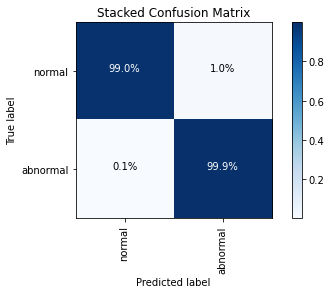

In [9]:
labels = np.where(y_test > 0, 1, y_test)
print(classification_report(labels, preds, digits=5))
cm = confusion_matrix(labels, preds)
plot_confusion_matrix(cm, title='Stacked Confusion Matrix')

In [10]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

def kfold(model, X, y):
    scores = []
    skfold = StratifiedKFold(n_splits = 4)

    for train_index, test_index in skfold.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model.fit(X_train, y_train)
        
        ac = accuracy_score(np.where(y_test > 0, 1, y_test), model.predict(X_test))
        print('Accuracy of model for actual fold:', ac)
        scores.append(ac)
    return scores

In [11]:
results = kfold(sc, X_train, y_train)
np.mean(results)

10993/10993 [==============================] - 12s 1ms/step
Accuracy for Autoencoder: 0.6074769012082445
Accuracy for Random Forest: 1.0
5469/5469 [==============================] - 6s 1ms/step
Accuracy of model for actual fold: 0.99796
10993/10993 [==============================] - 12s 1ms/step
Accuracy for Autoencoder: 0.6076474769012082
Accuracy for Random Forest: 1.0
5469/5469 [==============================] - 8s 1ms/step
Accuracy of model for actual fold: 0.9980171428571428
10993/10993 [==============================] - 15s 1ms/step
Accuracy for Autoencoder: 0.6072096659559346
Accuracy for Random Forest: 1.0
5469/5469 [==============================] - 7s 1ms/step
Accuracy of model for actual fold: 0.9978914285714285
10993/10993 [==============================] - 14s 1ms/step
Accuracy for Autoencoder: 0.6079857853589197
Accuracy for Random Forest: 1.0
5469/5469 [==============================] - 6s 1ms/step
Accuracy of model for actual fold: 0.9981428571428571


0.9980028571428572

In [12]:
normal_traffic = X_test[np.where(y_test == 0)]
dos_traffic = X_test[np.where(y_test == 1)]
ddos_traffic = X_test[np.where(y_test == 2)]
bot_traffic = X_test[np.where(y_test == 3)]
bf_traffic = X_test[np.where(y_test == 4)]
inf_traffic = X_test[np.where(y_test == 5)]
web_traffic = X_test[np.where(y_test == 6)]

In [13]:
preds = sc.predict(normal_traffic)
accuracy_score(y_test[np.where(y_test == 0)[0]], preds)

20220/20220 [==============================] - 22s 1ms/step


0.9904499895674752

In [14]:
preds = sc.predict(dos_traffic)
accuracy_score(y_test[np.where(y_test == 1)[0]], preds)

3559/3559 [==============================] - 4s 1ms/step


0.9991657006358239

In [15]:
preds = sc.predict(ddos_traffic)
ddos = y_test[np.where(y_test == 2)[0]]
accuracy_score(np.where(ddos > 0, 1, ddos).astype(bool), preds)

1494/1494 [==============================] - 2s 1ms/step


0.99725970086811

In [16]:
preds = sc.predict(bot_traffic)
bot = y_test[np.where(y_test == 3)[0]]
accuracy_score(np.where(bot > 0, 1, bot).astype(bool), preds)

18/18 [==============================] - 0s 983us/step


0.9893805309734514

In [17]:
preds = sc.predict(bf_traffic)
bf = y_test[np.where(y_test == 4)[0]]
accuracy_score(np.where(bf > 0, 1, bf).astype(bool), preds)

128/128 [==============================] - 0s 1ms/step


1.0

In [18]:
preds = sc.predict(inf_traffic)
inf = y_test[np.where(y_test == 5)[0]]
accuracy_score(np.where(inf > 0, 1, inf).astype(bool), preds)

1/1 [==============================] - 0s 18ms/step


0.7777777777777778

In [19]:
preds = sc.predict(web_traffic)
web = y_test[np.where(y_test == 6)[0]]
accuracy_score(np.where(web > 0, 1, web).astype(bool), preds)

12/12 [==============================] - 0s 998us/step


0.9862637362637363